In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import torch
import torch.nn as nn

In [3]:
# Import relevant scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import AdaBoostRegressor

import time
from datetime import datetime
import os
from torch.nn.modules import padding
import random
import math
import utils

In [7]:
np.seterr(divide='ignore',invalid='ignore')

# Define path and csv files
DATA_DIR = '../data/suzuki/'
OUT_DIR = 'out/models_unimol_infer'+datetime.now().strftime('%y%m%d%H%M')+'/'
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
# 分子特征
INPUTS_reactant1_repr = 'reactant_1repr.csv'  # Unscaled  data 
INPUTS_reactant2_repr = 'reactant_2repr.csv'
INPUTS_reagent1_repr = 'reagent_1repr.csv'
INPUTS_solvent1_repr = 'solvent_1repr.csv'
INPUTS_ligand_repr = 'ligandrepr.csv'
INPUTS_Origin_DF = 'suzuki.xlsx'

inputs_reactant1_repr = pd.read_csv(DATA_DIR + INPUTS_reactant1_repr)
inputs_reactant2_repr = pd.read_csv(DATA_DIR + INPUTS_reactant2_repr)
inputs_reagent1_repr = pd.read_csv(DATA_DIR + INPUTS_reagent1_repr)
inputs_solvent1_repr = pd.read_csv(DATA_DIR + INPUTS_solvent1_repr)
inputs_Ligand_repr = pd.read_csv(DATA_DIR + INPUTS_ligand_repr)
df_ori = pd.read_excel(DATA_DIR + INPUTS_Origin_DF)
df = df_ori.dropna(axis=0, how='any')
yields = df['Output']*100

inputs = np.concatenate([inputs_reactant1_repr,inputs_reactant2_repr, inputs_reagent1_repr, inputs_solvent1_repr, inputs_Ligand_repr], axis=1)
 
# 随机生成train和test的indices
total_cleaned_len = len(inputs)
train_index = random.sample(range(total_cleaned_len), int(total_cleaned_len*0.7))#论文中用了600个作为训练集 int(1075*0.7)
train_indices = np.zeros((total_cleaned_len)).astype(np.bool_)
for tcl in range(total_cleaned_len):
    if tcl in train_index:
        train_indices[tcl] = True
test_indices = ~ train_indices
np.savetxt(OUT_DIR + 'clean_data_train_indices.csv', train_indices, delimiter = ',')
np.savetxt(OUT_DIR + 'clean_data_test_indices.csv', test_indices, delimiter = ',')

# Load yield data
yields = np.array(yields)
yields = yields.flatten()
#np.savetxt('delta2G_mini.csv', delta2G, fmt='%s')
# Yield data contains some NaNs to eliminate
yields = np.nan_to_num(yields, nan=0)
print('len(inputs): ', len(inputs))
# Use the indices to generate train/test sets
X_train = inputs[train_indices]
#X_train = inputs[:2]
y_train = yields[train_indices]
featuresTrain = torch.from_numpy(X_train)
targetsTrain = torch.from_numpy(y_train)
batch_size = len(X_train)
print('batch_size: ', batch_size)

X_test = inputs[test_indices]
y_test = yields[test_indices]
featuresTest = torch.from_numpy(X_test)
targetsTest = torch.from_numpy(y_test)#.type(torch.LongTensor)


batch_size_test = len(X_test)
print('batch_size_test: ', batch_size_test)

USE_OCCUPY_ATOMLEVEL = 1
num_epochs = 10000 # 100000

ann_input_dim = inputs.shape[1]#2930
print('ann_input_dim: ', ann_input_dim)
output_dim = 1

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size_test, shuffle = False)

len(inputs):  4620
batch_size:  3234
batch_size_test:  1386
ann_input_dim:  2560


In [5]:
class ModelANNUsingAtomlevel(nn.Module):
    def __init__(self, input_ann_dim, output_dim):
        super(ModelANNUsingAtomlevel, self).__init__()
                
        # Linear function 1: 784 --> 100
        #下面参数个数120*100=12000
        self.fc_1 = nn.Linear(input_ann_dim, 1000) 
        self.bn_1 = nn.BatchNorm1d(1000)
        # Non-linearity 1        
        self.relu_1 = nn.Sigmoid()
        #self.drop_1 = nn.Dropout(0.5)
        self.fc_2 = nn.Linear(1000, 500)
        self.bn_2 = nn.BatchNorm1d(500)
        # Non-linearity 1        
        self.relu_2 = nn.Sigmoid()

        if False:
            self.fc_3 = nn.Linear(500, 200)
            self.bn_3 = nn.BatchNorm1d(200)
            # Non-linearity 1        
            self.relu_3 = nn.Sigmoid()
            
            self.fc_4 = nn.Linear(200, 50)
            self.bn_4 = nn.BatchNorm1d(50)
            # Non-linearity 1        
            self.relu_4 = nn.Sigmoid()         
        self.fc_5 = nn.Linear(500, output_dim)  
    
    def forward(self, x):
        
        # Linear function 1
        out = self.fc_1(x)
        out = self.bn_1(out)
        # Non-linearity 1
        out = self.relu_1(out)
        #out = self.drop_1(out)
        # Linear function 1
        out = self.fc_2(out)
        out = self.bn_2(out)
        # Non-linearity 1
        out = self.relu_2(out)# Linear function 1

        if False:
            out = self.fc_3(out)
            out = self.bn_3(out)
            # Non-linearity 1
            out = self.relu_3(out)        
            
            out = self.fc_4(out)
            out = self.bn_4(out)
            # Non-linearity 1
            out = self.relu_4(out)
        
        # Linear function 4 (readout)
        out = self.fc_5(out)
        return out

error = nn.MSELoss()

def squared_loss(y_true, y_pred):
    """Compute the squared loss for regression.

    Parameters
    ----------
    y_true : array-like or label indicator matrix
        Ground truth (correct) values.

    y_pred : array-like or label indicator matrix
        Predicted values, as returned by a regression estimator.

    Returns
    -------
    loss : float
        The degree to which the samples are correctly predicted.
    """
    return ((y_true - y_pred) ** 2).mean() / 2

def delt2G(ee):
    #LN(G2)*8.314472*293.15/1000*0.2389
    EPSINON = 1e-5
    ee[ee > (100.0 - EPSINON)] = 100.0 - EPSINON        
    ee[ee < (-100.0 + EPSINON)] = -100.0 + EPSINON
    R = 8.314472#理想气体常数
    T = 23 + 273.15#作者论文用了23摄氏度减去绝对零度-273.15，转换成热力学温度
    J2K = 0.2389#焦转卡
    ln_Er = np.log((100+ee)/(100-ee))#np包和math包中的log就是ln, cmath中的是log本身
    return ln_Er*R*T/1000*J2K

AdaBoostRegressor(n_estimators=100, random_state=42)
LinearRegression()
LinearSVR(max_iter=10000)
KNeighborsRegressor(n_neighbors=7)
RandomForestRegressor(n_estimators=50, random_state=42)
ModelANNUsingAtomlevel(
  (fc_1): Linear(in_features=2560, out_features=1000, bias=True)
  (bn_1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): Sigmoid()
  (fc_2): Linear(in_features=1000, out_features=500, bias=True)
  (bn_2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): Sigmoid()
  (fc_5): Linear(in_features=500, out_features=1, bias=True)
)
Done fitting models


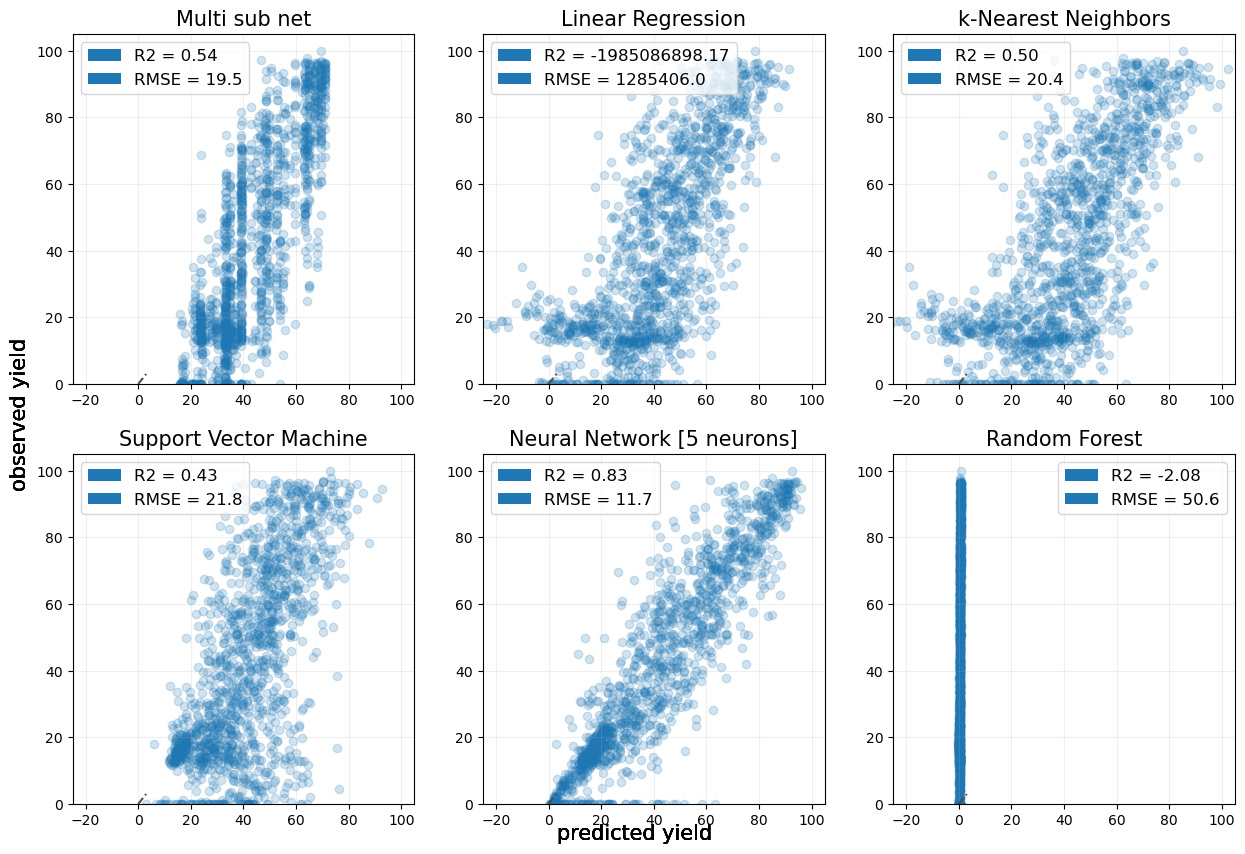

In [9]:
            
#---------
models_need_fit = [AdaBoostRegressor(n_estimators=100, random_state=42),
                   LinearRegression(),
                   LinearSVR(max_iter=10000),
                   KNeighborsRegressor(n_neighbors=7), 
                   RandomForestRegressor(n_estimators=50,random_state=42),
                   #RandomForestRegressor(n_estimators=100,random_state=42)#,
                   ]
# model_nn = torch.load('models_trained/nn/best_model_epoch_399_20210526193859.pkl')
model_nn = torch.load('./out/models_unimol_infer2405081644/best_model_epoch_5449_20240508165538.pkl')
models_already_fitted = [model_nn]
# models_already_fitted = []
preds, r2_values, rmse_values  = utils.load_or_fit_models(X_train,
                                                          X_test,
                                                          y_train,
                                                          y_test,
                                                          models_need_fit,
                                                          models_already_fitted
                                                          )
utils.plot_models_Sun(preds,
                  r2_values,
                  rmse_values,
                  y_test)